## Setup

In [93]:
#!pip install transformers torch scikit-learn matplotlib seaborn tqdm pandas numpy -q

In [94]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import os
import random

warnings.filterwarnings('ignore')


SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

PyTorch: 2.6.0+cu124
CUDA: True


## these are configs to for the dataset, all the training details and to normailize overfitting

In [95]:

DATA_PATH = "/kaggle/input/cleaned-sentiment-analysis/cleaned_sentiment_analysis.csv"
OUTPUT_DIR = "outputs"
MODEL_DIR = "outputs/best_model"


MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128
DROPOUT = 0.1


BATCH_SIZE = 8
LR = 3e-5
EPOCHS = 7
GRAD_ACCUM = 4  
WARMUP = 0.1
PATIENCE = 3 

AUGMENT = True
BALANCE_RATIO = 1.0 

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {DEVICE}")
print(f"Batch: {BATCH_SIZE} x {GRAD_ACCUM} = {BATCH_SIZE * GRAD_ACCUM}")

Device: cuda
Batch: 8 x 4 = 32


## subtle preprocessing

In [96]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

## adding more negative data and positive the negative was less

In [97]:
# Synonym dictionary
SYNONYMS = {
    'good': ['great', 'excellent', 'wonderful', 'fantastic', 'nice'],
    'love': ['adore', 'enjoy', 'appreciate', 'like'],
    'amazing': ['incredible', 'awesome', 'outstanding', 'superb'],
    'best': ['finest', 'greatest', 'top', 'superior'],
    'bad': ['terrible', 'awful', 'horrible', 'poor', 'worst'],
    'hate': ['dislike', 'despise', 'detest'],
    'terrible': ['awful', 'dreadful', 'horrible', 'atrocious'],
    'worst': ['poorest', 'lowest', 'inferior'],
    'disappointed': ['unsatisfied', 'unhappy', 'frustrated']
}

def replace_synonyms(text, n=2):
    words = text.split()
    if len(words) < 2:
        return text
    
    new_words = words.copy()
    indices = random.sample(range(len(words)), min(n, len(words)))
    
    for i in indices:
        if words[i] in SYNONYMS:
            new_words[i] = random.choice(SYNONYMS[words[i]])
    
    return ' '.join(new_words)

def delete_random(text, p=0.15):
    words = text.split()
    if len(words) == 1:
        return text
    new_words = [w for w in words if random.random() > p]
    return ' '.join(new_words) if new_words else random.choice(words)

def swap_words(text, n=2):
    words = text.split()
    if len(words) < 2:
        return text
    
    new_words = words.copy()
    for _ in range(n):
        if len(new_words) >= 2:
            i, j = random.sample(range(len(new_words)), 2)
            new_words[i], new_words[j] = new_words[j], new_words[i]
    
    return ' '.join(new_words)

def augment(text, num=1):
    results = []
    methods = [replace_synonyms, delete_random, swap_words]
    
    for _ in range(num):
        aug_text = text
        for method in random.sample(methods, random.randint(2, 3)):
            try:
                aug_text = method(aug_text)
            except:
                pass
        
        if aug_text and aug_text != text and len(aug_text.split()) > 2:
            results.append(aug_text)
    
    return results

In [98]:
# Load data
df = pd.read_csv(DATA_PATH)
print(f"Loaded: {df.shape}")

# Remove duplicate header if exists
if df.iloc[0]['text'] == 'Text':
    df = df.iloc[1:].reset_index(drop=True)

# Clean
df = df.dropna()
df['text'] = df['text'].apply(clean_text)
df = df[df['text'].str.len() > 0]
df['sentiment'] = df['sentiment'].str.lower().str.strip()

# Map labels
label_map = {'positive': 1, 'negative': 0}
df['label'] = df['sentiment'].map(label_map).astype(int)

print(f"After cleaning: {df.shape}")
print(df['sentiment'].value_counts())

Loaded: (97, 2)
After cleaning: (96, 3)
sentiment
positive    53
negative    43
Name: count, dtype: int64


## negative positive equal

In [99]:
if AUGMENT:
    counts = df['label'].value_counts()
    majority = counts.idxmax()
    minority = counts.idxmin()
    
    target = int(counts[majority] * BALANCE_RATIO)
    needed = target - counts[minority]
    
    print(f"Need {needed} augmented samples")
    
    if needed > 0:
        minority_df = df[df['label'] == minority]
        aug_samples = []
        per_sample = needed // len(minority_df) + 1
        
        for _, row in tqdm(minority_df.iterrows(), total=len(minority_df)):
            for aug_text in augment(row['text'], per_sample):
                aug_samples.append({
                    'text': aug_text,
                    'sentiment': row['sentiment'],
                    'label': row['label']
                })
                if len(aug_samples) >= needed:
                    break
            if len(aug_samples) >= needed:
                break
        
        df = pd.concat([df, pd.DataFrame(aug_samples)], ignore_index=True)
        df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
        
        print(f"Final: {df.shape}")
        print(df['label'].value_counts())

Need 10 augmented samples


 26%|██▌       | 11/43 [00:00<00:00, 6832.13it/s]

Final: (106, 3)
label
0    53
1    53
Name: count, dtype: int64


## 75/15/10 split

In [100]:

train_val, test = train_test_split(df, test_size=0.1, random_state=SEED, stratify=df['label'])
train, val = train_test_split(train_val, test_size=0.15/0.85, random_state=SEED, stratify=train_val['label'])

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

Train: 78, Val: 17, Test: 11


In [101]:
counts = train['label'].value_counts().sort_index()
weights = [len(train) / (2 * c) for c in counts]
class_weights = torch.FloatTensor(weights).to(DEVICE)
print(f"Weights: {weights}")

Weights: [1.0, 1.0]


## dataset w attention

In [102]:
class SentimentData(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, i):
        text = str(self.texts.iloc[i])
        label = self.labels.iloc[i]
        
        enc = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [103]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

train_data = SentimentData(train['text'].reset_index(drop=True), train['label'].reset_index(drop=True), tokenizer, MAX_LEN)
val_data = SentimentData(val['text'].reset_index(drop=True), val['label'].reset_index(drop=True), tokenizer, MAX_LEN)
test_data = SentimentData(test['text'].reset_index(drop=True), test['label'].reset_index(drop=True), tokenizer, MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

print(f"Batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Batches - Train: 10, Val: 3, Test: 2


## initalizling the model

In [104]:
class SentimentClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop1 = nn.Dropout(DROPOUT)
        self.fc1 = nn.Linear(768, 384)
        self.bn = nn.BatchNorm1d(384)
        self.relu = nn.ReLU()
        self.drop2 = nn.Dropout(DROPOUT)
        self.fc2 = nn.Linear(384, 2)
        
        # Init weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
    
    def forward(self, input_ids, mask):
        out = self.bert(input_ids=input_ids, attention_mask=mask)
        x = self.drop1(out.pooler_output)
        x = self.fc1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.drop2(x)
        return self.fc2(x)

model = SentimentClassifier().to(DEVICE)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Parameters: 109,779,074


In [105]:
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

optimizer = AdamW([
    {'params': model.bert.parameters(), 'lr': LR},
    {'params': list(model.fc1.parameters()) + list(model.fc2.parameters()), 'lr': LR * 10}
], weight_decay=0.01)

total_steps = len(train_loader) * EPOCHS // GRAD_ACCUM
warmup_steps = int(total_steps * WARMUP)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

print(f"Steps: {total_steps}, Warmup: {warmup_steps}")

Steps: 17, Warmup: 1


In [106]:
def train_epoch(model, loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    optimizer.zero_grad()
    
    for i, batch in enumerate(tqdm(loader, desc="Training")):
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        logits = model(ids, mask)
        loss = criterion(logits, labels) / GRAD_ACCUM
        loss.backward()
        
        if (i + 1) % GRAD_ACCUM == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * GRAD_ACCUM
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Eval"):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(ids, mask)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return total_loss / len(loader), 100 * correct / total

In [107]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

best_f1 = 0
history = []
no_improve = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, DEVICE)
    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)
    
    # Get F1
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            ids = batch['input_ids'].to(DEVICE)
            mask = batch['attention_mask'].to(DEVICE)
            y = batch['labels'].to(DEVICE)
            
            logits = model(ids, mask)
            preds.extend(logits.argmax(1).cpu().numpy())
            labels.extend(y.cpu().numpy())
    
    val_f1 = f1_score(labels, preds, average='weighted')
    
    history.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'val_f1': val_f1
    })
    
    print(f"Train: {train_loss:.4f} / {train_acc:.2f}%")
    print(f"Val: {val_loss:.4f} / {val_acc:.2f}% / F1: {val_f1:.4f}")
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        no_improve = 0
        torch.save(model.state_dict(), f"{MODEL_DIR}/model.pt")
        tokenizer.save_pretrained(MODEL_DIR)
        print(f"Saved! Best F1: {val_f1:.4f}")
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"No improvement for {PATIENCE} epochs. Stopping early.")
            break
        print(f"No improvement ({no_improve}/{PATIENCE})")

print(f"\nDone! Best F1: {best_f1:.4f}")
print(f"Trained for {len(history)} epochs")


Epoch 1/7


Eval: 100%|██████████| 3/3 [00:00<00:00, 36.53it/s]


Train: 0.8042 / 57.69%
Val: 0.6416 / 70.59% / F1: 0.6997
Saved! Best F1: 0.6997

Epoch 2/7


Eval: 100%|██████████| 3/3 [00:00<00:00, 35.60it/s]


Train: 0.6934 / 69.23%
Val: 0.3519 / 94.12% / F1: 0.9408
Saved! Best F1: 0.9408

Epoch 3/7


Eval: 100%|██████████| 3/3 [00:00<00:00, 37.17it/s]


Train: 0.5387 / 82.05%
Val: 0.2901 / 94.12% / F1: 0.9408
No improvement (1/3)

Epoch 4/7


Eval: 100%|██████████| 3/3 [00:00<00:00, 37.41it/s]


Train: 0.4115 / 89.74%
Val: 0.2834 / 88.24% / F1: 0.8798
No improvement (2/3)

Epoch 5/7


Eval: 100%|██████████| 3/3 [00:00<00:00, 37.14it/s]


Train: 0.4718 / 82.05%
Val: 0.2686 / 94.12% / F1: 0.9408
No improvement for 3 epochs. Stopping early.

Done! Best F1: 0.9408
Trained for 5 epochs


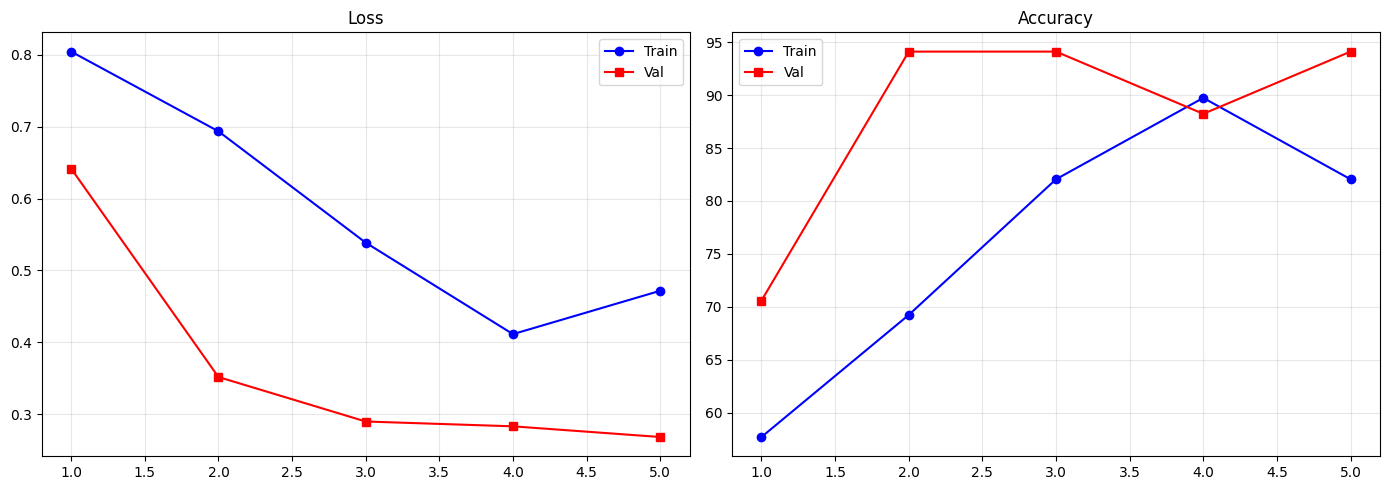

   epoch  train_loss  train_acc  val_loss    val_acc    val_f1
0      1    0.804206  57.692308  0.641566  70.588235  0.699690
1      2    0.693429  69.230769  0.351937  94.117647  0.940764
2      3    0.538664  82.051282  0.290113  94.117647  0.940764
3      4    0.411536  89.743590  0.283403  88.235294  0.879832
4      5    0.471810  82.051282  0.268562  94.117647  0.940764


In [108]:
# Plot training
stats = pd.DataFrame(history)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(stats['epoch'], stats['train_loss'], 'b-o', label='Train')
ax1.plot(stats['epoch'], stats['val_loss'], 'r-s', label='Val')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(stats['epoch'], stats['train_acc'], 'b-o', label='Train')
ax2.plot(stats['epoch'], stats['val_acc'], 'r-s', label='Val')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/training.png", dpi=200)
plt.show()

print(stats)

## Test Evaluation

In [109]:
model.load_state_dict(torch.load(f"{MODEL_DIR}/model.pt"))
model.eval()

preds, labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader):
        ids = batch['input_ids'].to(DEVICE)
        mask = batch['attention_mask'].to(DEVICE)
        y = batch['labels'].to(DEVICE)
        
        logits = model(ids, mask)
        preds.extend(logits.argmax(1).cpu().numpy())
        labels.extend(y.cpu().numpy())

preds = np.array(preds)
labels = np.array(labels)

100%|██████████| 2/2 [00:00<00:00, 38.55it/s]


In [110]:
acc = accuracy_score(labels, preds)
f1_macro = f1_score(labels, preds, average='macro')
f1_weighted = f1_score(labels, preds, average='weighted')

print(f"\nTest Results:")
print(f"Accuracy: {acc * 100:.2f}%")
print(f"F1 (macro): {f1_macro:.4f}")
print(f"F1 (weighted): {f1_weighted:.4f}")
print("\n" + classification_report(labels, preds, target_names=['Negative', 'Positive']))


Test Results:
Accuracy: 90.91%
F1 (macro): 0.9091
F1 (weighted): 0.9091

              precision    recall  f1-score   support

    Negative       1.00      0.83      0.91         6
    Positive       0.83      1.00      0.91         5

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.91        11
weighted avg       0.92      0.91      0.91        11



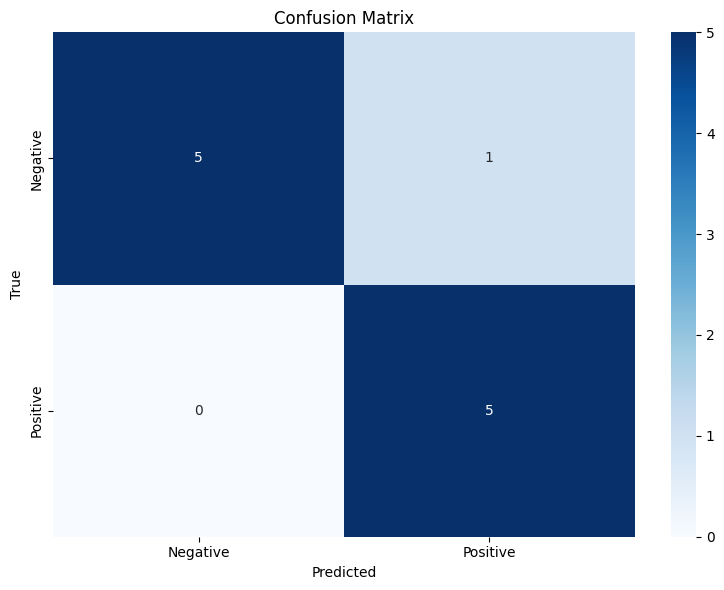

In [111]:

cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/confusion.png", dpi=200)
plt.show()

## Predictions

In [112]:
def predict(text):
    model.eval()
    cleaned = clean_text(text)
    
    enc = tokenizer.encode_plus(
        cleaned,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    ids = enc['input_ids'].to(DEVICE)
    mask = enc['attention_mask'].to(DEVICE)
    
    with torch.no_grad():
        logits = model(ids, mask)
        probs = torch.softmax(logits, dim=1)[0]
        pred = probs.argmax().item()
    
    sentiment = 'positive' if pred == 1 else 'negative'
    
    print(f"\nText: {text}")
    print(f"Sentiment: {sentiment.upper()}")
    print(f"Confidence: {probs[pred] * 100:.1f}%")
    print(f"  Negative: {probs[0] * 100:.1f}%")
    print(f"  Positive: {probs[1] * 100:.1f}%")

In [113]:
# Test predictions
examples = [
    "This product is amazing! I love it!",
    "Terrible service. Very disappointed.",
    "Best purchase ever! Highly recommend!",
    "Worst experience. Complete waste of money.",
    "The food was delicious and staff friendly.",
    "Poor quality. Broke after one use."
]

for text in examples:
    predict(text)


Text: This product is amazing! I love it!
Sentiment: POSITIVE
Confidence: 84.2%
  Negative: 15.8%
  Positive: 84.2%

Text: Terrible service. Very disappointed.
Sentiment: NEGATIVE
Confidence: 90.4%
  Negative: 90.4%
  Positive: 9.6%

Text: Best purchase ever! Highly recommend!
Sentiment: POSITIVE
Confidence: 75.8%
  Negative: 24.2%
  Positive: 75.8%

Text: Worst experience. Complete waste of money.
Sentiment: NEGATIVE
Confidence: 62.5%
  Negative: 62.5%
  Positive: 37.5%

Text: The food was delicious and staff friendly.
Sentiment: POSITIVE
Confidence: 65.7%
  Negative: 34.3%
  Positive: 65.7%

Text: Poor quality. Broke after one use.
Sentiment: NEGATIVE
Confidence: 90.6%
  Negative: 90.6%
  Positive: 9.4%


In [114]:
print("\nSummary:")
print(f"Dataset: {len(df)} samples")
print(f"Train/Val/Test: {len(train)}/{len(val)}/{len(test)}")
print(f"Test Accuracy: {acc * 100:.2f}%")
print(f"Test F1: {f1_weighted:.4f}")
print(f"\nModel saved to: {MODEL_DIR}")


Summary:
Dataset: 106 samples
Train/Val/Test: 78/17/11
Test Accuracy: 90.91%
Test F1: 0.9091

Model saved to: outputs/best_model
